<a href="https://colab.research.google.com/github/LauraMattz/e_bikes_2022_2025/blob/main/e_bikes_2022_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚲⚡ Boom de Bikes e Patinetes Elétricos no Brasil (2022–2025)

Este notebook analisa a evolução das importações de bicicletas, patinetes e scooters elétricos no Brasil, com base em dados públicos do Comex Stat (MDIC).

**Ferramentas:** Python, pandas, matplotlib, geopandas, Google Colab

⚠️ *Dados de 2025 são parciais.*

## 1. Contexto

Nos últimos anos, a mobilidade elétrica leve tornou-se visível nas ruas brasileiras. Este estudo investiga se essa percepção é confirmada pelos dados de importação.

## 2. Fonte dos dados

Dados públicos do **Comex Stat / MDIC**, acessados via API.

**NCM analisado:** 8711.60.00 — inclui bicicletas, patinetes e scooters elétricos.

## 3. Metodologia

Pipeline analítico:
1. Download automatizado dos microdados
2. Limpeza e tratamento com pandas
3. Agregação por ano e UF
4. Cálculo de quantidade, valor FOB e proxy de preço

⚠️ UF de importação não representa necessariamente consumo final.

## Setup do ambiente

Instala dependências e cria pastas.

In [1]:

!pip -q install comexdown pandas pyarrow tqdm matplotlib geopandas shapely requests

import os, glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

DATA_DIR = "data"
OUT_DIR = "out"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

print("OK ✅ Pastas:", DATA_DIR, OUT_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
OK ✅ Pastas: data out


## Baixar dados automaticamente (2022–2025)

O `comexdown trade` baixa **exportação e importação** por ano. Aqui usamos apenas os arquivos de **importação** (`data/imp/IMP_YYYY.csv`).

⚠️ Esses arquivos podem ser grandes. Se o Colab reclamar de espaço, rode ano a ano (2022, 2023, 2024, 2025).

In [2]:

# Download em lote (pode demorar e ocupar espaço)
# Se der problema, comente a linha abaixo e baixe ano a ano.
!comexdown trade 2022:2025 -o data

# Alternativa ano a ano:
# for year in [2022, 2023, 2024, 2025]:
#     !comexdown trade {year} -o data

print("Arquivos baixados (amostra):")
for p in sorted(glob.glob("data/imp/IMP_*.csv"))[:10]:
    print("-", p)


Downloading: https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/EXP_2022.csv --> EXP_2022.csv
[==================================================] 100.0% (95.03 MiB)
Downloading: https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_2022.csv --> IMP_2022.csv
[==================================================] 100.0% (141.76 MiB)
Downloading: https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/EXP_2023.csv --> EXP_2023.csv
[==================================================] 100.0% (99.12 MiB)
Downloading: https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_2023.csv --> IMP_2023.csv
[==================================================] 100.0% (145.88 MiB)
Downloading: https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/EXP_2024.csv --> EXP_2024.csv
[==================================================] 100.0% (101.76 MiB)
Downloading: https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_2024.csv --> IMP_2024.csv
[==================

## Ler e empilhar anos (somente colunas necessárias)

Colunas esperadas nos arquivos `IMP_YYYY.csv`:
- `CO_ANO`, `CO_MES`, `CO_NCM`, `SG_UF_NCM`, `QT_ESTAT`, `VL_FOB`

Vamos filtrar o **NCM 87116000** e agregar por **UF + ano**.

In [3]:

USECOLS = ["CO_ANO","CO_MES","CO_NCM","SG_UF_NCM","QT_ESTAT","VL_FOB"]

paths = sorted(glob.glob("data/imp/IMP_*.csv"))
assert len(paths) > 0, "Nenhum arquivo data/imp/IMP_*.csv encontrado. Rode a célula de download."

dfs = []
for path in tqdm(paths, desc="Lendo CSVs de importação"):
    year = int(os.path.basename(path).split("_")[1].split(".")[0])  # IMP_2024.csv -> 2024
    d = pd.read_csv(path, sep=";", usecols=USECOLS, low_memory=False)
    d["ANO_ARQ"] = year  # redundante, mas ajuda em debug
    dfs.append(d)

raw = pd.concat(dfs, ignore_index=True)
raw.shape


Lendo CSVs de importação: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


(8783076, 7)

### Filtrar NCM 87116000 e criar colunas úteis

In [4]:

NCM = 87116000

df = raw[raw["CO_NCM"] == NCM].copy()

# ano/mês e datas (para checar completude de 2025)
df["date"] = pd.to_datetime(dict(year=df["CO_ANO"], month=df["CO_MES"], day=1), errors="coerce")
df["ano"] = df["CO_ANO"].astype(int)

df.head(), df.shape


(       CO_ANO  CO_MES    CO_NCM SG_UF_NCM  QT_ESTAT  VL_FOB  ANO_ARQ       date   ano
 628      2022       4  87116000        PA        60    9313     2022 2022-04-01  2022
 9693     2022      12  87116000        RJ      1357  151945     2022 2022-12-01  2022
 32142    2022       3  87116000        SC       369  923886     2022 2022-03-01  2022
 36751    2022       6  87116000        AP         6    3298     2022 2022-06-01  2022
 38008    2022      12  87116000        PI         6    2288     2022 2022-12-01  2022,
 (1478, 9))

## Tabela-mãe por UF + ano

Saída principal (para análises e mapas):

| ano | UF | quantidade | valor_usd | usd_por_unidade |
|---:|:--:|---:|---:|---:|

In [5]:

by_uf_year = (
    df.groupby(["ano","SG_UF_NCM"], as_index=False)
      .agg(
          quantidade=("QT_ESTAT","sum"),
          valor_usd=("VL_FOB","sum"),
      )
)

by_uf_year["usd_por_unidade"] = by_uf_year["valor_usd"] / by_uf_year["quantidade"].replace(0, np.nan)
by_uf_year = by_uf_year.rename(columns={"SG_UF_NCM":"uf"}).sort_values(["ano","uf"]).reset_index(drop=True)

by_uf_year.head(10)


,ano,uf,quantidade,valor_usd,usd_por_unidade
0,2022,AL,58121,1450599,24.958259
1,2022,AM,990,906848,916.008081
2,2022,AP,137,53830,392.919708
3,2022,CE,76,64711,851.460526
4,2022,DF,45,846,18.800000
5,2022,ES,3365,2738490,813.815750
6,2022,GO,218,147025,674.426606
7,2022,MA,5,8731,1746.200000
8,2022,MG,17605,1295467,73.585175
9,2022,MS,70,11550,165.000000


### Checagem rápida de completude de 2025

Se 2025 estiver parcial (ex.: só até setembro), isso deve ser mencionado no texto final.

In [6]:

# meses disponíveis por ano no dataset filtrado
months_by_year = (df.dropna(subset=["date"])
                    .assign(mes=lambda x: x["date"].dt.month)
                    .groupby("ano")["mes"]
                    .nunique()
                    .sort_index())

months_by_year


,mes
ano,
2022,12
2023,12
2024,12
2025,12


## Comparação SP vs RJ (por ano)

Vamos comparar:
- quantidade
- valor_usd
- usd_por_unidade (proxy de preço)

para SP e RJ, de 2022 a 2025.

In [7]:

comp = by_uf_year[by_uf_year["uf"].isin(["SP","RJ"])].copy()

# pivots para facilitar leitura
pivot_q = comp.pivot(index="ano", columns="uf", values="quantidade")
pivot_v = comp.pivot(index="ano", columns="uf", values="valor_usd")
pivot_p = comp.pivot(index="ano", columns="uf", values="usd_por_unidade")

pivot_q, pivot_v, pivot_p


(uf       RJ      SP
 ano                
 2022  19924   11360
 2023  20455   33138
 2024  50752   80374
 2025  96641  108419,
 uf          RJ       SP
 ano                    
 2022   2726675  1919404
 2023   3591203  2739202
 2024   9285474  6426266
 2025  17520194  9558936,
 uf            RJ          SP
 ano                         
 2022  136.853794  168.961620
 2023  175.566023   82.660450
 2024  182.957795   79.954538
 2025  181.291522   88.166613)

### Gráficos SP vs RJ (2022–2025)

Observação: 2025 pode estar parcial. Compare tendências, mas evite concluir 'ano fechado' se faltarem meses.

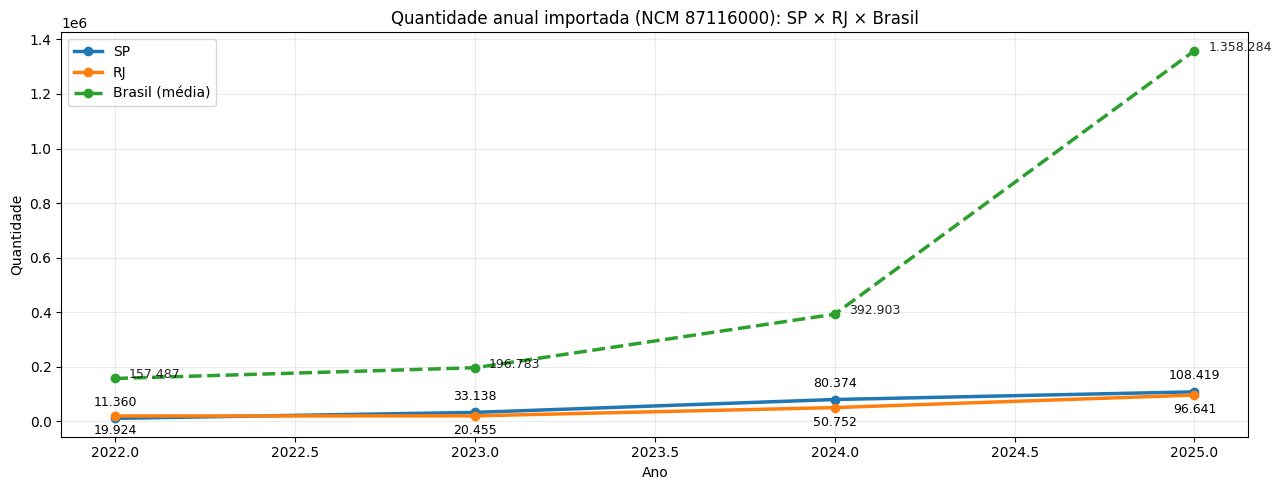

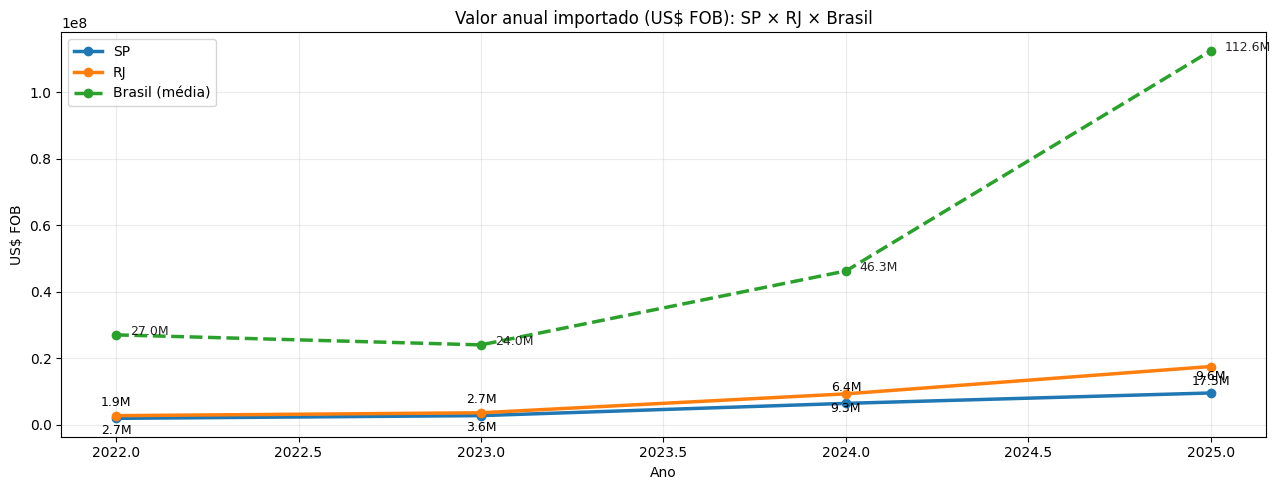

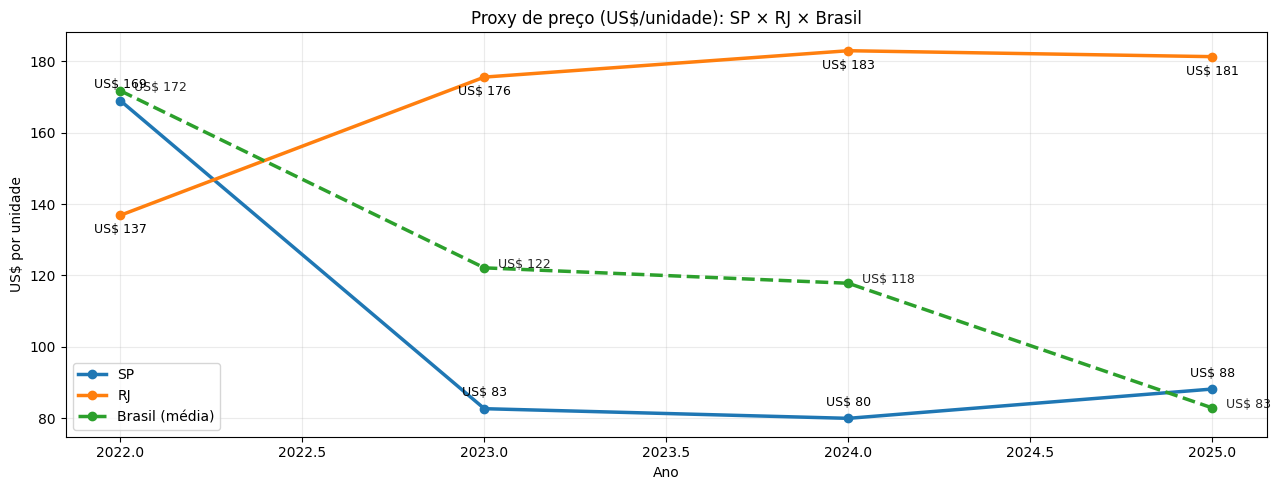

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def _fmt_value(x, kind):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    if kind == "int":
        return f"{int(round(x)):,}".replace(",", ".")
    if kind == "money":
        if abs(x) >= 1_000_000:
            return f"{x/1_000_000:.1f}M"
        if abs(x) >= 1_000:
            return f"{x/1_000:.1f}k"
        return f"{int(round(x)):,}".replace(",", ".")
    if kind == "price":
        return f"US$ {int(round(x))}"
    return str(x)

def plot_three_series(
    index, a, b, c,
    title, ylabel,
    label_a="SP", label_b="RJ", label_c="Brasil (média)",
    kind="int"  # "int", "money", "price"
):
    fig, ax = plt.subplots(figsize=(13,5))

    ax.plot(index, a, marker="o", linewidth=2.5, label=label_a)
    ax.plot(index, b, marker="o", linewidth=2.5, label=label_b)
    ax.plot(index, c, marker="o", linewidth=2.5, linestyle="--", label=label_c)

    ax.set_title(title)
    ax.set_xlabel("Ano")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)
    ax.legend()

    # rótulos
    for x, y in zip(index, a):
        if not (isinstance(y, float) and np.isnan(y)):
            ax.annotate(_fmt_value(y, kind), (x, y),
                        textcoords="offset points", xytext=(0, 9),
                        ha="center", fontsize=9)

    for x, y in zip(index, b):
        if not (isinstance(y, float) and np.isnan(y)):
            ax.annotate(_fmt_value(y, kind), (x, y),
                        textcoords="offset points", xytext=(0, -13),
                        ha="center", fontsize=9)

    for x, y in zip(index, c):
        if not (isinstance(y, float) and np.isnan(y)):
            ax.annotate(_fmt_value(y, kind), (x, y),
                        textcoords="offset points", xytext=(10, 0),
                        ha="left", fontsize=9, alpha=0.85)

    plt.tight_layout()
    plt.show()

# Brasil agregado por ano
br = (
    by_uf_year
    .groupby("ano", as_index=False)
    .agg(
        quantidade=("quantidade", "sum"),
        valor_usd=("valor_usd", "sum")
    )
)

br["usd_por_unidade"] = br["valor_usd"] / br["quantidade"]
br = br.set_index("ano")

plot_three_series(
    pivot_q.index,
    pivot_q.get("SP"),
    pivot_q.get("RJ"),
    br["quantidade"],
    "Quantidade anual importada (NCM 87116000): SP × RJ × Brasil",
    "Quantidade",
    kind="int"
)

plot_three_series(
    pivot_v.index,
    pivot_v.get("SP"),
    pivot_v.get("RJ"),
    br["valor_usd"],
    "Valor anual importado (US$ FOB): SP × RJ × Brasil",
    "US$ FOB",
    kind="money"
)

plot_three_series(
    pivot_p.index,
    pivot_p.get("SP"),
    pivot_p.get("RJ"),
    br["usd_por_unidade"],
    "Proxy de preço (US$/unidade): SP × RJ × Brasil",
    "US$ por unidade",
    kind="price"
)


## Resumo em texto

Gera um texto com:
- ranking SP vs RJ no ano
- variação 2022 → 2025 (ou último ano disponível) em cada UF
- nota sobre 2025 parcial

In [9]:
import numpy as np
import pandas as pd

USD_BRL = 5.00  # ajuste aqui (ex.: média anual)

def fmt_int_br(x):
    return f"{int(round(float(x))):,}".replace(",", ".")

def fmt_money_compact(x, prefix=""):
    x = float(x)
    ax = abs(x)
    if ax >= 1_000_000:
        return f"{prefix}{x/1_000_000:.1f}M"
    if ax >= 1_000:
        return f"{prefix}{x/1_000:.1f}k"
    return f"{prefix}{fmt_int_br(x)}"

def fmt_usd(x): return fmt_money_compact(x, "US$ ")
def fmt_brl(x): return fmt_money_compact(x, "R$ ")

def fmt_pct(x):
    # robusto: funciona mesmo se pd tiver sido sobrescrito em outra célula
    try:
        if x is None:
            return "—"
        if isinstance(x, (float, np.floating)) and np.isnan(x):
            return "—"
        return f"{float(x):.1f}%"
    except Exception:
        return "—"

def build_summary_for_year(year):
    sub = by_uf_year[by_uf_year["ano"] == year].copy()

    if not (sub["uf"].isin(["SP"]).any() and sub["uf"].isin(["RJ"]).any()):
        return f"⚠️ {year}: faltam dados de SP ou RJ."

    sp = sub[sub["uf"] == "SP"].iloc[0]
    rj = sub[sub["uf"] == "RJ"].iloc[0]

    lead_q = "SP" if sp["quantidade"] >= rj["quantidade"] else "RJ"
    # se tiver NaN, cai para o outro ou marca —
    if pd.isna(sp["usd_por_unidade"]) and pd.isna(rj["usd_por_unidade"]):
        lead_p = "—"
    elif pd.isna(rj["usd_por_unidade"]):
        lead_p = "SP"
    elif pd.isna(sp["usd_por_unidade"]):
        lead_p = "RJ"
    else:
        lead_p = "SP" if sp["usd_por_unidade"] >= rj["usd_por_unidade"] else "RJ"

    lines = []
    lines.append(f"🗓️ {year} — SP x RJ (NCM 87116000)")
    lines.append(f"🚲 Quantidade: SP {fmt_int_br(sp['quantidade'])} | RJ {fmt_int_br(rj['quantidade'])}")
    lines.append(f"💰 Valor (US$): SP {fmt_usd(sp['valor_usd'])} | RJ {fmt_usd(rj['valor_usd'])}")
    lines.append(
        f"🏷️ Proxy preço (US$/unid): "
        f"SP {fmt_money_compact(sp['usd_por_unidade'],'US$ ')} | "
        f"RJ {fmt_money_compact(rj['usd_por_unidade'],'US$ ')}"
    )
    lines.append(f"🔎 Liderança: volume → {lead_q} | proxy de preço → {lead_p}")
    return "\n".join(lines)

years = sorted(by_uf_year["ano"].unique())

print("📌 Resumo por ano")
print("\n\n".join(build_summary_for_year(y) for y in years))

# -------------------------
# Comparação 2022 -> último ano disponível
# -------------------------
start_year = 2022 if 2022 in years else years[0]
end_year = years[-1]

def delta_uf(uf, metric):
    s = by_uf_year[(by_uf_year["ano"] == start_year) & (by_uf_year["uf"] == uf)][metric]
    e = by_uf_year[(by_uf_year["ano"] == end_year) & (by_uf_year["uf"] == uf)][metric]
    if len(s) == 0 or len(e) == 0:
        return None
    s = float(s.iloc[0])
    e = float(e.iloc[0])
    pct = (e - s) / s * 100 if s != 0 else np.nan
    return s, e, e - s, pct

print("\n" + "=" * 80 + "\n")
print(f"📈 Comparação {start_year} → {end_year} (atenção: {end_year} pode ser parcial)\n")

for uf in ["SP", "RJ"]:
    dq = delta_uf(uf, "quantidade")
    dv = delta_uf(uf, "valor_usd")
    dp = delta_uf(uf, "usd_por_unidade")

    if dq is None or dv is None or dp is None:
        print(f"⚠️ Sem dados suficientes para {uf}\n")
        continue

    q0, q1, qd, qp = dq
    v0, v1, vd, vp = dv
    p0, p1, pdiff, pp = dp

    print(f"📍 {uf}")
    print(f"  🚲 Quantidade: {fmt_int_br(q0)} → {fmt_int_br(q1)} (Δ {fmt_int_br(qd)}, {fmt_pct(qp)})")
    print(f"  💰 Valor (US$): {fmt_usd(v0)} → {fmt_usd(v1)} (Δ {fmt_usd(vd)}, {fmt_pct(vp)})")
    print(f"  💰 Valor (R$):  {fmt_brl(v0 * USD_BRL)} → {fmt_brl(v1 * USD_BRL)}")
    print(f"  🏷️ Proxy preço: {fmt_money_compact(p0,'US$ ')} → {fmt_money_compact(p1,'US$ ')} (Δ {fmt_money_compact(pdiff,'US$ ')}, {fmt_pct(pp)})")
    print("")

# Nota de completude para 2025 (se months_by_year existir)
try:
    if end_year == 2025 and int(months_by_year.get(2025, 12)) < 12:
        print(f"⚠️ Nota: 2025 está parcial ({int(months_by_year.get(2025))} meses no dataset). Compare com cautela.")
except Exception:
    pass


📌 Resumo por ano
🗓️ 2022 — SP x RJ (NCM 87116000)
🚲 Quantidade: SP 11.360 | RJ 19.924
💰 Valor (US$): SP US$ 1.9M | RJ US$ 2.7M
🏷️ Proxy preço (US$/unid): SP US$ 169 | RJ US$ 137
🔎 Liderança: volume → RJ | proxy de preço → SP

🗓️ 2023 — SP x RJ (NCM 87116000)
🚲 Quantidade: SP 33.138 | RJ 20.455
💰 Valor (US$): SP US$ 2.7M | RJ US$ 3.6M
🏷️ Proxy preço (US$/unid): SP US$ 83 | RJ US$ 176
🔎 Liderança: volume → SP | proxy de preço → RJ

🗓️ 2024 — SP x RJ (NCM 87116000)
🚲 Quantidade: SP 80.374 | RJ 50.752
💰 Valor (US$): SP US$ 6.4M | RJ US$ 9.3M
🏷️ Proxy preço (US$/unid): SP US$ 80 | RJ US$ 183
🔎 Liderança: volume → SP | proxy de preço → RJ

🗓️ 2025 — SP x RJ (NCM 87116000)
🚲 Quantidade: SP 108.419 | RJ 96.641
💰 Valor (US$): SP US$ 9.6M | RJ US$ 17.5M
🏷️ Proxy preço (US$/unid): SP US$ 88 | RJ US$ 181
🔎 Liderança: volume → SP | proxy de preço → RJ


📈 Comparação 2022 → 2025 (atenção: 2025 pode ser parcial)

📍 SP
  🚲 Quantidade: 11.360 → 108.419 (Δ 97.059, 854.4%)
  💰 Valor (US$): US$ 1.9M → US$

## Mapa do Brasil

Vamos criar mapas por ano (ou um ano específico) usando um GeoJSON de estados.

In [10]:

import geopandas as gpd
import requests

# 1) Tentativa 1: GeoJSON público (estados do Brasil)
URLS = [
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
    "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"  # fallback (pode não ser estados)
]

gdf = None
for url in URLS:
    try:
        gdf_try = gpd.read_file(url)
        # Heurística: manter apenas se parece conter UFs (coluna com sigla)
        cols = [c.lower() for c in gdf_try.columns]
        if any("sigla" in c for c in cols) or any("abbr" in c for c in cols) or any("uf" == c for c in cols):
            gdf = gdf_try
            print("✅ GeoJSON carregado:", url)
            break
        # click_that_hood costuma ter 'name' com nomes de estados; manter mesmo assim
        if "name" in gdf_try.columns and len(gdf_try) <= 30:
            gdf = gdf_try
            print("✅ GeoJSON carregado:", url)
            break
    except Exception as e:
        print("Falhou:", url, "|", type(e).__name__)

assert gdf is not None, "Não consegui carregar um GeoJSON. Tente outra fonte de shape/geojson."

print("Colunas no GeoDataFrame:", list(gdf.columns))
gdf.head()


✅ GeoJSON carregado: https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson
Colunas no GeoDataFrame: ['id', 'name', 'sigla', 'regiao_id', 'codigo_ibg', 'cartodb_id', 'created_at', 'updated_at', 'geometry']


,id,name,sigla,regiao_id,codigo_ibg,cartodb_id,created_at,updated_at,geometry
0,1,Acre,AC,3,12,1,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-73.60818 -7.20194, -72.86963 ..."
1,2,Alagoas,AL,4,27,2,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-35.46516 -8.82549, -35.46626 ..."
2,3,Amazonas,AM,3,13,3,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-67.32553 2.03012, -67.32234 2..."
3,4,Amapá,AP,3,16,4,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-51.18168 4.00889, -51.179 3.9..."
4,5,Bahia,BA,4,29,5,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-39.2882 -8.5629, -39.28229 -8..."


### Preparar chave de UF no mapa

In [11]:

# Mapa de nomes -> sigla (para casar com by_uf_year.uf)
name_to_uf = {
    "Acre":"AC","Alagoas":"AL","Amapá":"AP","Amazonas":"AM","Bahia":"BA","Ceará":"CE",
    "Distrito Federal":"DF","Espírito Santo":"ES","Goiás":"GO","Maranhão":"MA",
    "Mato Grosso":"MT","Mato Grosso do Sul":"MS","Minas Gerais":"MG","Pará":"PA",
    "Paraíba":"PB","Paraná":"PR","Pernambuco":"PE","Piauí":"PI","Rio de Janeiro":"RJ",
    "Rio Grande do Norte":"RN","Rio Grande do Sul":"RS","Rondônia":"RO","Roraima":"RR",
    "Santa Catarina":"SC","São Paulo":"SP","Sergipe":"SE","Tocantins":"TO"
}

g = gdf.copy()

# Cria coluna 'uf' a partir de possíveis colunas
if "uf" in [c.lower() for c in g.columns]:
    # se já tiver 'uf' (ou variação), tenta achar exatamente
    for c in g.columns:
        if c.lower() == "uf":
            g["uf"] = g[c]
            break
elif any("sigla" in c.lower() for c in g.columns):
    c = [c for c in g.columns if "sigla" in c.lower()][0]
    g["uf"] = g[c]
elif any("abbr" in c.lower() for c in g.columns):
    c = [c for c in g.columns if "abbr" in c.lower()][0]
    g["uf"] = g[c]
elif "name" in g.columns:
    # assume que name = nome do estado
    g["uf"] = g["name"].map(name_to_uf)
else:
    raise ValueError("Não encontrei coluna para derivar UF. Ajuste o mapeamento manualmente.")

# manter só linhas com UF válida
g = g[g["uf"].isin(by_uf_year["uf"].unique())].copy()
g[["uf"]].head(), g.shape


(   uf
 1  AL
 2  AM
 3  AP
 4  BA
 5  CE,
 (26, 10))

### Função de mapa por ano

Gera choropleth por UF para um ano e uma métrica (`quantidade`, `valor_usd`, `usd_por_unidade`).

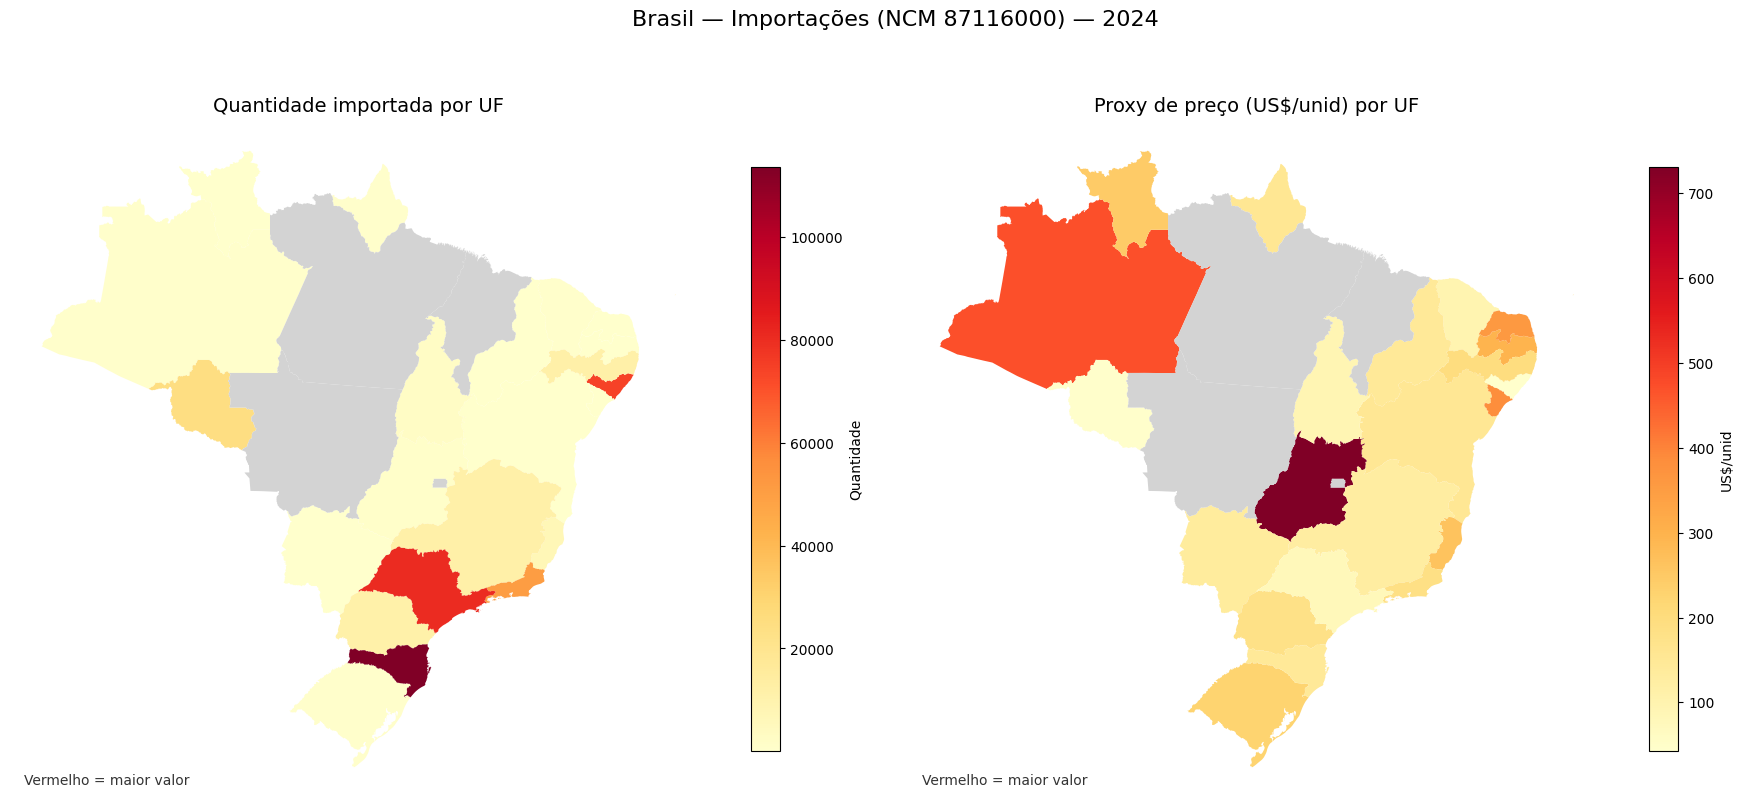

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_two_maps_side_by_side(
    year,
    metric_left,
    metric_right,
    title_left,
    title_right,
    legend_left,
    legend_right,
    cmap="YlOrRd",
    log_scale_left=False,
    log_scale_right=False
):
    # dados do ano
    sub = by_uf_year[by_uf_year["ano"] == year][["uf", metric_left, metric_right]].copy()
    gg = g.merge(sub, on="uf", how="left")

    fig, axes = plt.subplots(1, 2, figsize=(18, 9))

    # -------------------------
    # MAPA ESQUERDA
    # -------------------------
    vmin_l = gg[metric_left].min(skipna=True)
    vmax_l = gg[metric_left].max(skipna=True)

    norm_l = (
        colors.LogNorm(vmin=vmin_l, vmax=vmax_l)
        if log_scale_left and vmin_l > 0
        else colors.Normalize(vmin=vmin_l, vmax=vmax_l)
    )

    gg.plot(
        column=metric_left,
        ax=axes[0],
        cmap=cmap,
        norm=norm_l,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": legend_left, "shrink": 0.7}
    )

    axes[0].set_title(title_left, fontsize=14)
    axes[0].axis("off")
    axes[0].annotate(
        "Vermelho = maior valor",
        xy=(0.02, 0.02),
        xycoords="axes fraction",
        fontsize=10,
        alpha=0.8
    )

    # -------------------------
    # MAPA DIREITA
    # -------------------------
    vmin_r = gg[metric_right].min(skipna=True)
    vmax_r = gg[metric_right].max(skipna=True)

    norm_r = (
        colors.LogNorm(vmin=vmin_r, vmax=vmax_r)
        if log_scale_right and vmin_r > 0
        else colors.Normalize(vmin=vmin_r, vmax=vmax_r)
    )

    gg.plot(
        column=metric_right,
        ax=axes[1],
        cmap=cmap,
        norm=norm_r,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": legend_right, "shrink": 0.7}
    )

    axes[1].set_title(title_right, fontsize=14)
    axes[1].axis("off")
    axes[1].annotate(
        "Vermelho = maior valor",
        xy=(0.02, 0.02),
        xycoords="axes fraction",
        fontsize=10,
        alpha=0.8
    )

    plt.suptitle(
        f"Brasil — Importações (NCM {NCM}) — {year}",
        fontsize=16,
        y=0.98
    )

    plt.tight_layout()
    plt.show()

plot_two_maps_side_by_side(
    year=2024,
    metric_left="quantidade",
    metric_right="usd_por_unidade",
    title_left="Quantidade importada por UF",
    title_right="Proxy de preço (US$/unid) por UF",
    legend_left="Quantidade",
    legend_right="US$/unid",
    cmap="YlOrRd",
    log_scale_left=False,   # True se SP dominar demais
    log_scale_right=False
)


## Exportar tabelas

Salva a tabela-mãe e a comparação SP/RJ.

In [14]:

by_uf_year.to_parquet(f"{OUT_DIR}/by_uf_year.parquet", index=False)
by_uf_year.to_csv(f"{OUT_DIR}/by_uf_year.csv", index=False)

comp.to_csv(f"{OUT_DIR}/sp_rj_2022_2025.csv", index=False)

print("Arquivos salvos em:", OUT_DIR)
sorted(os.listdir(OUT_DIR))


Arquivos salvos em: out


['by_uf_year.csv', 'by_uf_year.parquet', 'sp_rj_2022_2025.csv']

In [15]:
import numpy as np
import pandas as pd

# =========================
# Config
# =========================
NCM = 87116000  # bikes/patinetes/scooters elétricos (proxy)
TOP_N_ESTADOS = None  # ex.: 10 para top 10; None para todos

# =========================
# Fonte esperada:
# df deve conter colunas:
# ['CO_ANO','CO_NCM','SG_UF_NCM','QT_ESTAT','VL_FOB']
# =========================

# garante nomes padronizados
d = df.copy()
if "SG_UF_NCM" in d.columns and "uf" not in d.columns:
    d = d.rename(columns={"SG_UF_NCM":"uf"})
if "CO_ANO" in d.columns and "ano" not in d.columns:
    d["ano"] = d["CO_ANO"].astype(int)

# filtra NCM (se df ainda não estiver filtrado)
d = d[d["CO_NCM"] == NCM].copy()

# agrega por ano + estado
by_ano_uf = (
    d.groupby(["ano","uf"], as_index=False)
     .agg(
         quantidade=("QT_ESTAT","sum"),
         valor_usd=("VL_FOB","sum"),
     )
)

# preço médio ponderado (valor total / quantidade total)
by_ano_uf["usd_por_unidade"] = by_ano_uf["valor_usd"] / by_ano_uf["quantidade"].replace(0, np.nan)

# opcional: manter só top N estados por valor (no período todo)
if TOP_N_ESTADOS is not None:
    top = (by_ano_uf.groupby("uf")["valor_usd"].sum().sort_values(ascending=False).head(TOP_N_ESTADOS).index)
    by_ano_uf = by_ano_uf[by_ano_uf["uf"].isin(top)].copy()

# ordena bonitinho
by_ano_uf = by_ano_uf.sort_values(["ano","valor_usd"], ascending=[True, False]).reset_index(drop=True)

# arredondamento só para exibição (não destrói precisão: se quiser, comente)
by_ano_uf["valor_usd"] = by_ano_uf["valor_usd"].round(2)
by_ano_uf["usd_por_unidade"] = by_ano_uf["usd_por_unidade"].round(2)

display(by_ano_uf.head(20))
print("Linhas:", len(by_ano_uf), "| Anos:", sorted(by_ano_uf["ano"].unique()), "| Estados:", by_ano_uf["uf"].nunique())




,ano,uf,quantidade,valor_usd,usd_por_unidade
0,2022,PE,13795,7376365,534.71
1,2022,SC,26523,7267300,274.00
2,2022,ES,3365,2738490,813.82
3,2022,RJ,19924,2726675,136.85
4,2022,SP,11360,1919404,168.96
5,2022,AL,58121,1450599,24.96
6,2022,MG,17605,1295467,73.59
7,2022,AM,990,906848,916.01
8,2022,PR,2040,564572,276.75
9,2022,RO,1871,219622,117.38


Linhas: 91 | Anos: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)] | Estados: 27


## Geração de Imagens

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors

OUT_DIR = "out_frames"
os.makedirs(OUT_DIR, exist_ok=True)

def plot_two_maps_side_by_side_save(
    year,
    metric_left="quantidade",
    metric_right="usd_por_unidade",
    title_left="Quantidade importada por UF",
    title_right="Preço médio (US$/unid) por UF",
    legend_left="Quantidade",
    legend_right="US$/unid",
    cmap="YlOrRd",
    log_scale_left=False,
    log_scale_right=False
):
    sub = by_uf_year[by_uf_year["ano"] == year][["uf", metric_left, metric_right]].copy()
    gg = g.merge(sub, on="uf", how="left")

    fig, axes = plt.subplots(1, 2, figsize=(18, 9))

    # normalização por frame (se quiser escala fixa entre anos, eu adapto)
    vmin_l = gg[metric_left].min(skipna=True)
    vmax_l = gg[metric_left].max(skipna=True)
    vmin_r = gg[metric_right].min(skipna=True)
    vmax_r = gg[metric_right].max(skipna=True)

    norm_l = colors.LogNorm(vmin=vmin_l, vmax=vmax_l) if (log_scale_left and vmin_l > 0) else colors.Normalize(vmin=vmin_l, vmax=vmax_l)
    norm_r = colors.LogNorm(vmin=vmin_r, vmax=vmax_r) if (log_scale_right and vmin_r > 0) else colors.Normalize(vmin=vmin_r, vmax=vmax_r)

    # esquerda
    gg.plot(
        column=metric_left,
        ax=axes[0],
        cmap=cmap,
        norm=norm_l,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": legend_left, "shrink": 0.55}
    )
    axes[0].set_title(title_left, fontsize=14)
    axes[0].axis("off")

    # direita
    gg.plot(
        column=metric_right,
        ax=axes[1],
        cmap=cmap,
        norm=norm_r,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": legend_right, "shrink": 0.55}
    )
    axes[1].set_title(title_right, fontsize=14)
    axes[1].axis("off")

    # rótulos das UFs (bem suaves)
    for _, row in gg.iterrows():
        if row.geometry is None:
            continue
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        for ax in axes:
            ax.text(x, y, row["uf"], ha="center", va="center", fontsize=8, alpha=0.35, color="black")

    # ano dentro de cada mapa
    for ax in axes:
        ax.text(
            0.98, 0.96, str(year),
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=18, fontweight="bold", alpha=0.85,
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.65)
        )

    fig.suptitle(f"Brasil — Importações (NCM {NCM})", fontsize=16, y=0.98)
    fig.tight_layout()

    return fig

# Gera os frames corretamente (SEM plt.show)
YEARS = sorted(by_uf_year["ano"].unique())
frame_paths = []

for y in YEARS:
    fig = plot_two_maps_side_by_side_save(year=y)
    path = f"{OUT_DIR}/frame_{y}.png"
    fig.savefig(path, dpi=150, bbox_inches="tight", facecolor="white")
    plt.close(fig)
    frame_paths.append(path)
    print("✅ Frame salvo:", path)

print("Pronto! Total frames:", len(frame_paths))


✅ Frame salvo: out_frames/frame_2022.png
✅ Frame salvo: out_frames/frame_2023.png
✅ Frame salvo: out_frames/frame_2024.png
✅ Frame salvo: out_frames/frame_2025.png
Pronto! Total frames: 4


✅ Imagem final salva em: out_frames/mapas_2022_2025_vertical.png


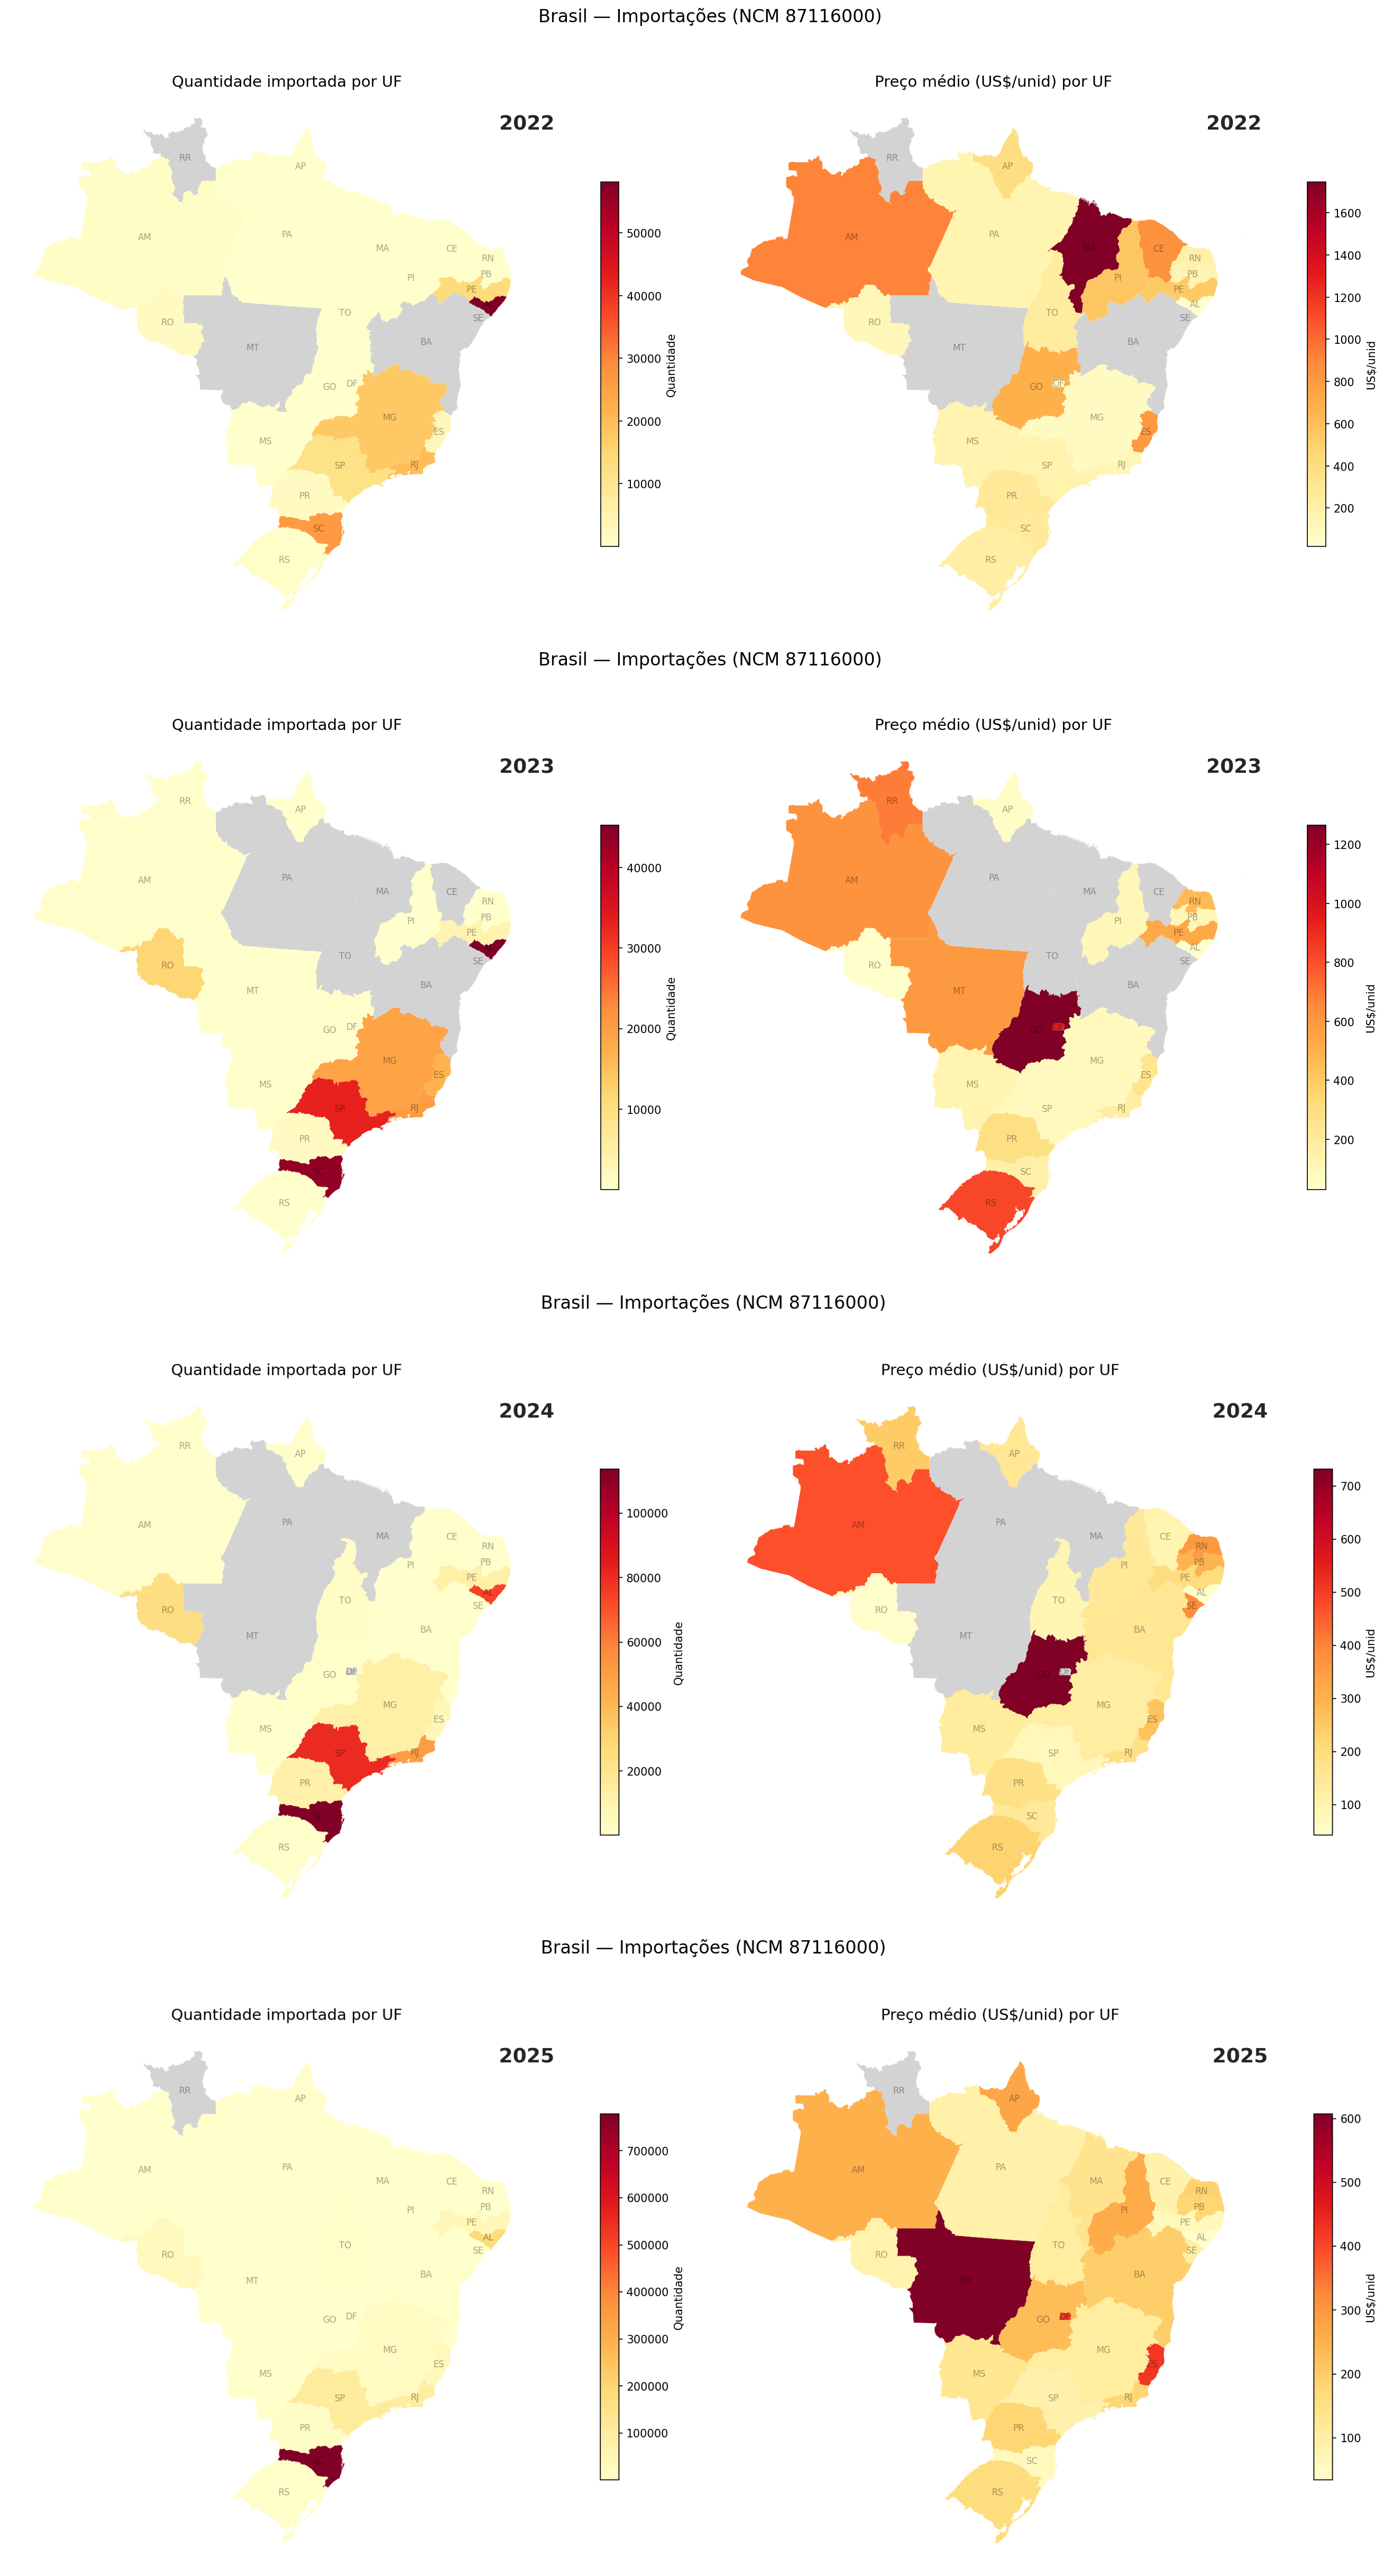

In [17]:
from PIL import Image
import glob
import os
from IPython.display import display

OUT_DIR = "out_frames"

png_paths = sorted(glob.glob(f"{OUT_DIR}/frame_*.png"))
assert len(png_paths) > 0, "❌ Nenhum frame encontrado. Rode a célula 1."

imgs = []
for p in png_paths:
    im = Image.open(p).convert("RGBA")
    bg = Image.new("RGBA", im.size, (255, 255, 255, 255))
    im = Image.alpha_composite(bg, im).convert("RGB")  # remove alpha sem virar branco
    imgs.append(im)

# mesma largura
max_width = max(im.width for im in imgs)
resized = []
for im in imgs:
    if im.width != max_width:
        new_h = int(im.height * max_width / im.width)
        im = im.resize((max_width, new_h))
    resized.append(im)

total_height = sum(im.height for im in resized)
final_img = Image.new("RGB", (max_width, total_height), (255, 255, 255))

y = 0
for im in resized:
    final_img.paste(im, (0, y))
    y += im.height

FINAL_PATH = f"{OUT_DIR}/mapas_{min(YEARS)}_{max(YEARS)}_vertical.png"
final_img.save(FINAL_PATH, quality=95)

print("✅ Imagem final salva em:", FINAL_PATH)
display(final_img)
